<a href="https://colab.research.google.com/github/Afsaumutoniwase/Time_Series_Forecasting/blob/main/air_quality_forecasting_starter_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beijing Air Quality Forecasting Starter Notebook

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, Bidirectional, Attention, Input, Concatenate, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Mount Google Drive to access datasets (for Colab only)
# Uncomment the lines below if running in Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the datasets
# Update these paths to match your local file paths
train = pd.read_csv('/content/drive/MyDrive/Time Series Assignment/train.csv')  # Update with your actual train.csv path
test = pd.read_csv('/content/drive/MyDrive/Time Series Assignment/test.csv')    # Update with your actual test.csv path

print("Data loaded successfully!")
print(f"Training data shape: {train.shape}")
print(f"Test data shape: {test.shape}")

Data loaded successfully!
Training data shape: (30676, 12)
Test data shape: (13148, 11)


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

Training Data Overview:
   No      DEWP      TEMP      PRES       Iws        Is        Ir  \
0   1 -1.580878 -1.922250  0.443328 -0.441894 -0.069353 -0.137667   
1   2 -1.580878 -2.004228  0.345943 -0.379306 -0.069353 -0.137667   
2   3 -1.580878 -1.922250  0.248559 -0.343514 -0.069353 -0.137667   
3   4 -1.580878 -2.168183  0.248559 -0.280926 -0.069353 -0.137667   
4   5 -1.511594 -2.004228  0.151174 -0.218339 -0.069353 -0.137667   

              datetime   cbwd_NW   cbwd_SE   cbwd_cv  pm2.5  
0  2010-01-01 00:00:00  1.448138 -0.732019 -0.522096    NaN  
1  2010-01-01 01:00:00  1.448138 -0.732019 -0.522096    NaN  
2  2010-01-01 02:00:00  1.448138 -0.732019 -0.522096    NaN  
3  2010-01-01 03:00:00  1.448138 -0.732019 -0.522096    NaN  
4  2010-01-01 04:00:00  1.448138 -0.732019 -0.522096    NaN  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30676 entries, 0 to 30675
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    -----------

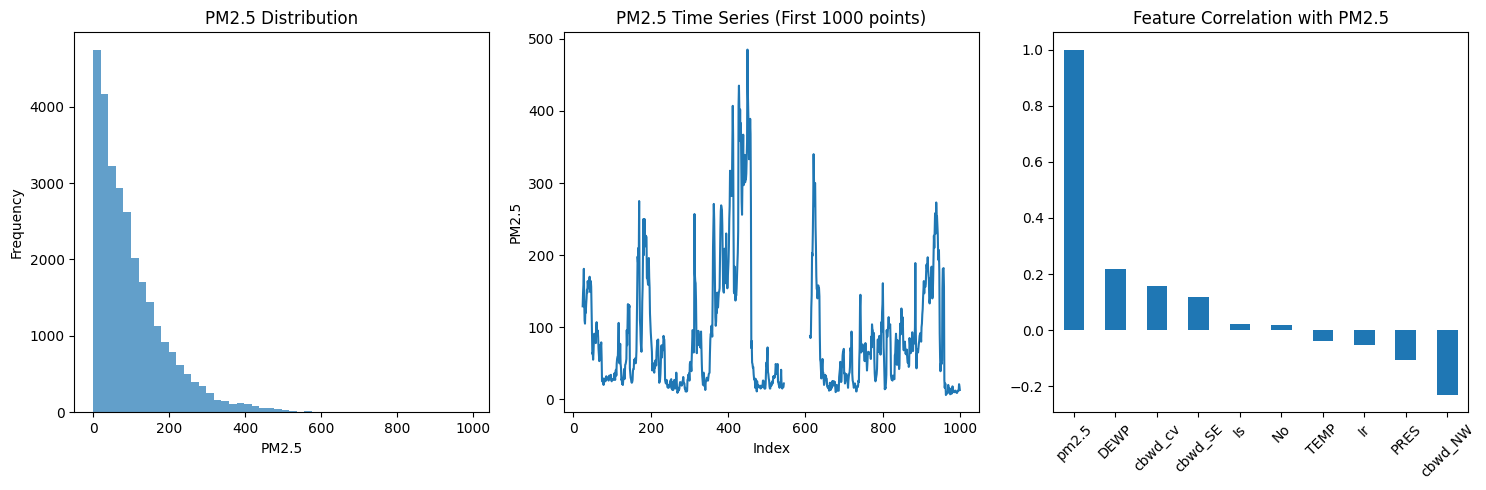


Feature correlations with PM2.5:
pm2.5      1.000000
DEWP       0.218187
cbwd_cv    0.158033
cbwd_SE    0.118986
Is         0.022279
No         0.017961
TEMP      -0.039601
Ir        -0.052288
PRES      -0.107773
cbwd_NW   -0.231176
Iws       -0.260250
Name: pm2.5, dtype: float64


In [4]:
# Comprehensive data exploration
print("Training Data Overview:")
print(train.head())
print("\nDataset Info:")
print(train.info())
print("\nStatistical Summary:")
print(train.describe())
print("\nMissing Values:")
print(train.isnull().sum())

# Check for target variable distribution
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(train['pm2.5'], bins=50, alpha=0.7)
plt.title('PM2.5 Distribution')
plt.xlabel('PM2.5')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.plot(train.index[:1000], train['pm2.5'][:1000])
plt.title('PM2.5 Time Series (First 1000 points)')
plt.xlabel('Index')
plt.ylabel('PM2.5')

plt.subplot(1, 3, 3)
correlation_matrix = train.select_dtypes(include=[np.number]).corr()['pm2.5'].sort_values(ascending=False)
correlation_matrix[:-1].plot(kind='bar')
plt.title('Feature Correlation with PM2.5')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nFeature correlations with PM2.5:")
print(correlation_matrix)

In [5]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [6]:
# Enhanced data preprocessing with time features
def create_time_features(df):
    """Create comprehensive time-based features"""
    df = df.copy()

    # Ensure datetime is the index
    if 'datetime' in df.columns:
        df['datetime'] = pd.to_datetime(df['datetime'])
        df.set_index('datetime', inplace=True)

    # Extract time features
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofweek'] = df.index.dayofweek
    df['weekofyear'] = df.index.isocalendar().week
    df['quarter'] = df.index.quarter

    # Cyclical features (important for time series)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['weekday_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

    # Season indicators
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['is_winter'] = ((df['month'] == 12) | (df['month'] <= 2)).astype(int)
    df['is_spring'] = ((df['month'] >= 3) & (df['month'] <= 5)).astype(int)
    df['is_summer'] = ((df['month'] >= 6) & (df['month'] <= 8)).astype(int)
    df['is_autumn'] = ((df['month'] >= 9) & (df['month'] <= 11)).astype(int)

    # Rush hours
    df['is_rush_hour'] = ((df['hour'] >= 7) & (df['hour'] <= 9) |
                         (df['hour'] >= 17) & (df['hour'] <= 19)).astype(int)

    return df

# Apply time feature engineering
train_enhanced = create_time_features(train)
test_enhanced = create_time_features(test)

print("Enhanced features created successfully!")
print(f"Training data shape after feature engineering: {train_enhanced.shape}")
print(f"New features added: {set(train_enhanced.columns) - set(train.columns)}")

Enhanced features created successfully!
Training data shape after feature engineering: (30676, 32)
New features added: {'is_rush_hour', 'day_sin', 'hour_cos', 'day', 'day_cos', 'is_weekend', 'hour', 'month', 'year', 'weekday_cos', 'weekofyear', 'is_winter', 'hour_sin', 'is_autumn', 'is_summer', 'month_sin', 'is_spring', 'dayofweek', 'weekday_sin', 'month_cos', 'quarter'}


# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [7]:
# Advanced missing value handling and outlier treatment
def handle_missing_values_and_outliers(df, target_col=None):
    """Advanced missing value handling and outlier treatment"""
    df = df.copy()

    # For numeric columns, use forward fill then backward fill, then mean
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        # Forward fill (use previous value)
        df[col] = df[col].fillna(method='ffill')
        # Backward fill for any remaining NaNs
        df[col] = df[col].fillna(method='bfill')
        # Fill any remaining with mean
        df[col] = df[col].fillna(df[col].mean())

    # Outlier treatment using IQR method (only for non-target columns)
    if target_col:
        cols_to_treat = [col for col in numeric_cols if col != target_col]
    else:
        cols_to_treat = numeric_cols

    for col in cols_to_treat:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Cap outliers instead of removing them (better for time series)
        df[col] = np.clip(df[col], lower_bound, upper_bound)

    return df

# Apply advanced preprocessing
train_processed = handle_missing_values_and_outliers(train_enhanced, 'pm2.5')
test_processed = handle_missing_values_and_outliers(test_enhanced)

print("Advanced preprocessing completed!")
print(f"Missing values in train: {train_processed.isnull().sum().sum()}")
print(f"Missing values in test: {test_processed.isnull().sum().sum()}")

Advanced preprocessing completed!
Missing values in train: 0
Missing values in test: 0


# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [9]:
# Advanced feature engineering with lag and rolling features
def create_lag_and_rolling_features(df, target_col='pm2.5', feature_cols=None):
    """Create lag features and rolling statistics"""
    df = df.copy()

    if feature_cols is None:
        # Select numeric columns excluding target
        feature_cols = [col for col in df.select_dtypes(include=[np.number]).columns
                       if col != target_col and col != 'No']

    # Create lag features for key variables
    important_features = ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM'] if any(col in df.columns for col in ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']) else feature_cols[:5]

    for feature in important_features:
        if feature in df.columns:
            # Lag features
            for lag in [1, 2, 3, 6, 12, 24]:
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

            # Rolling statistics
            for window in [6, 12, 24, 48]:
                df[f'{feature}_rolling_mean_{window}'] = df[feature].rolling(window=window, min_periods=1).mean()
                df[f'{feature}_rolling_std_{window}'] = df[feature].rolling(window=window, min_periods=1).std()
                df[f'{feature}_rolling_max_{window}'] = df[feature].rolling(window=window, min_periods=1).max()
                df[f'{feature}_rolling_min_{window}'] = df[feature].rolling(window=window, min_periods=1).min()

    # Target lag features (only for training data)
    if target_col in df.columns:
        for lag in [1, 2, 3, 6, 12, 24]:
            df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)

        # Rolling statistics for target
        for window in [6, 12, 24, 48]:
            df[f'{target_col}_rolling_mean_{window}'] = df[target_col].rolling(window=window, min_periods=1).mean()
            df[f'{target_col}_rolling_std_{window}'] = df[target_col].rolling(window=window, min_periods=1).std()

    # Interaction features
    if 'TEMP' in df.columns and 'PRES' in df.columns:
        df['TEMP_PRES_interaction'] = df['TEMP'] * df['PRES']
    if 'DEWP' in df.columns and 'TEMP' in df.columns:
        df['TEMP_DEWP_diff'] = df['TEMP'] - df['DEWP']
    if 'WSPM' in df.columns and 'RAIN' in df.columns:
        df['WIND_RAIN_interaction'] = df['WSPM'] * df['RAIN']

    return df

# Apply advanced feature engineering
print("Creating advanced features...")
train_final = create_lag_and_rolling_features(train_processed)
test_final = create_lag_and_rolling_features(test_processed, target_col=None)

# Handle any remaining NaN values created by lag features
train_final = train_final.fillna(method='bfill').fillna(train_final.mean())
test_final = test_final.fillna(method='bfill').fillna(test_final.mean())

print(f"Final training data shape: {train_final.shape}")
print(f"Final test data shape: {test_final.shape}")

# FIXED: Prepare features ensuring alignment between train and test
# Get feature columns that exist in both train and test datasets
train_feature_cols = [col for col in train_final.columns if col not in ['pm2.5', 'No']]
test_feature_cols = [col for col in test_final.columns if col not in ['pm2.5', 'No']]

# Use only features that exist in both datasets
common_feature_cols = [col for col in train_feature_cols if col in test_feature_cols]

print(f"Training features: {len(train_feature_cols)}")
print(f"Test features: {len(test_feature_cols)}")
print(f"Common features: {len(common_feature_cols)}")

# Use common features for both datasets
X_train_features = train_final[common_feature_cols]
y_train = train_final['pm2.5']
X_test_features = test_final[common_feature_cols]

# For test set, we'll create proxy target features using the mean from training data
# This is a common technique when target lag features are important
print("Creating proxy target features for test set...")
for lag in [1, 2, 3, 6, 12, 24]:
    col_name = f'pm2.5_lag_{lag}'
    if col_name in train_final.columns:
        # Use the mean value from training data for test set
        test_proxy_value = train_final[col_name].mean()
        X_test_features[col_name] = test_proxy_value

for window in [6, 12, 24, 48]:
    for stat in ['rolling_mean', 'rolling_std']:
        col_name = f'pm2.5_{stat}_{window}'
        if col_name in train_final.columns:
            # Use the mean value from training data for test set
            test_proxy_value = train_final[col_name].mean()
            X_test_features[col_name] = test_proxy_value

# Update feature columns to include the proxy target features
feature_cols = X_train_features.columns.tolist()
target_proxy_cols = [col for col in X_test_features.columns if col.startswith('pm2.5_') and col not in feature_cols]
feature_cols.extend(target_proxy_cols)

# Ensure both datasets have the same features
X_train_features = train_final[feature_cols]
X_test_features = X_test_features[feature_cols]

print(f"Final number of aligned features: {len(feature_cols)}")
print(f"Final X_train shape: {X_train_features.shape}")
print(f"Final X_test shape: {X_test_features.shape}")
print(f"Feature columns sample: {feature_cols[:10]}...")

Creating advanced features...
Final training data shape: (30676, 114)
Final test data shape: (13148, 99)
Training features: 112
Test features: 98
Common features: 98
Creating proxy target features for test set...
Final number of aligned features: 112
Final X_train shape: (30676, 112)
Final X_test shape: (13148, 112)
Feature columns sample: ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'hour']...


In [10]:
# Advanced sequence preparation for LSTM
def create_sequences(X, y, sequence_length=24):
    """Create sequences for LSTM input with proper time series structure"""
    X_seq, y_seq = [], []

    for i in range(sequence_length, len(X)):
        X_seq.append(X[i-sequence_length:i])
        y_seq.append(y[i])

    return np.array(X_seq), np.array(y_seq)

def create_test_sequences(X, sequence_length=24):
    """Create sequences for test data"""
    X_seq = []

    for i in range(sequence_length, len(X)):
        X_seq.append(X[i-sequence_length:i])

    return np.array(X_seq)

# Advanced scaling with multiple scalers
print("Applying advanced scaling...")

# Use RobustScaler for better handling of outliers
feature_scaler = RobustScaler()
target_scaler = StandardScaler()

# Scale features
X_train_scaled = feature_scaler.fit_transform(X_train_features)
X_test_scaled = feature_scaler.transform(X_test_features)

# Scale target
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()

# Create sequences for LSTM
SEQUENCE_LENGTH = 48  # Use 48 hours of data to predict next hour
print(f"Creating sequences with length: {SEQUENCE_LENGTH}")

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, SEQUENCE_LENGTH)
X_test_seq = create_test_sequences(X_test_scaled, SEQUENCE_LENGTH)

print(f"Training sequences shape: {X_train_seq.shape}")
print(f"Training targets shape: {y_train_seq.shape}")
print(f"Test sequences shape: {X_test_seq.shape}")

# Split into train and validation for better evaluation
split_idx = int(0.85 * len(X_train_seq))
X_train_final = X_train_seq[:split_idx]
y_train_final = y_train_seq[:split_idx]
X_val_final = X_train_seq[split_idx:]
y_val_final = y_train_seq[split_idx:]

print(f"Final training shape: {X_train_final.shape}")
print(f"Final validation shape: {X_val_final.shape}")

Applying advanced scaling...
Creating sequences with length: 48
Training sequences shape: (30628, 48, 112)
Training targets shape: (30628,)
Test sequences shape: (13100, 48, 112)
Final training shape: (26033, 48, 112)
Final validation shape: (4595, 48, 112)


# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [11]:
# Advanced LSTM Architecture with Attention and Bidirectional Layers
def create_advanced_model(input_shape):
    """Create an advanced LSTM model with attention mechanism"""

    # Input layer
    inputs = Input(shape=input_shape)

    # First LSTM layer - Bidirectional
    lstm1 = Bidirectional(LSTM(128, return_sequences=True,
                              dropout=0.2, recurrent_dropout=0.2))(inputs)
    lstm1 = BatchNormalization()(lstm1)

    # Second LSTM layer - Bidirectional
    lstm2 = Bidirectional(LSTM(64, return_sequences=True,
                              dropout=0.2, recurrent_dropout=0.2))(lstm1)
    lstm2 = BatchNormalization()(lstm2)

    # Third LSTM layer
    lstm3 = LSTM(32, return_sequences=False,
                 dropout=0.2, recurrent_dropout=0.2)(lstm2)
    lstm3 = BatchNormalization()(lstm3)

    # Dense layers with residual connections
    dense1 = Dense(128, activation='relu')(lstm3)
    dense1 = BatchNormalization()(dense1)
    dense1 = Dropout(0.3)(dense1)

    dense2 = Dense(64, activation='relu')(dense1)
    dense2 = BatchNormalization()(dense2)
    dense2 = Dropout(0.2)(dense2)

    dense3 = Dense(32, activation='relu')(dense2)
    dense3 = BatchNormalization()(dense3)
    dense3 = Dropout(0.1)(dense3)

    # Output layer
    outputs = Dense(1, activation='linear')(dense3)

    model = Model(inputs=inputs, outputs=outputs)

    return model

def create_gru_model(input_shape):
    """Create a GRU-based model for ensemble"""
    inputs = Input(shape=input_shape)

    # GRU layers
    gru1 = Bidirectional(GRU(96, return_sequences=True,
                            dropout=0.2, recurrent_dropout=0.2))(inputs)
    gru1 = BatchNormalization()(gru1)

    gru2 = GRU(48, return_sequences=False,
               dropout=0.2, recurrent_dropout=0.2)(gru1)
    gru2 = BatchNormalization()(gru2)

    # Dense layers
    dense1 = Dense(96, activation='relu')(gru2)
    dense1 = BatchNormalization()(dense1)
    dense1 = Dropout(0.2)(dense1)

    dense2 = Dense(48, activation='relu')(dense1)
    dense2 = Dropout(0.1)(dense2)

    outputs = Dense(1, activation='linear')(dense2)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the advanced LSTM model
print("Building advanced LSTM model...")
lstm_model = create_advanced_model((X_train_final.shape[1], X_train_final.shape[2]))

# Compile with advanced optimizer settings
lstm_model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
    loss='huber',  # More robust to outliers than MSE
    metrics=['mae', 'mse']
)

print("LSTM Model Architecture:")
lstm_model.summary()

# Create GRU model for ensemble
print("\nBuilding GRU model for ensemble...")
gru_model = create_gru_model((X_train_final.shape[1], X_train_final.shape[2]))

gru_model.compile(
    optimizer=Adam(learning_rate=0.0008),
    loss='huber',
    metrics=['mae', 'mse']
)

print("GRU Model Architecture:")
gru_model.summary()

Building advanced LSTM model...
LSTM Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 112)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 48, 256)        │       246,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 48, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 448,897 (1.71 MB)

 Trainable params: 447,617 (1.71 MB)

 Non-trainable params: 1,280 (5.00 KB)


Building GRU model for ensemble...
GRU Model Architecture:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 112)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 48, 192)        │       120,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 48, 192)        │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 48)             │        34,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 48)             │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │         4,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 96)             │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 48)             │         4,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,561 (650.63 KB)

 Trainable params: 165,889 (648.00 KB)

 Non-trainable params: 672 (2.62 KB)

In [ ]:
# Advanced training with ensemble approach
print("Training advanced models...")

# Enhanced callbacks
def create_callbacks(model_name):
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=7,
            restore_best_weights=True,
            verbose=1,
            min_delta=0.001
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.3,
            patience=7,
            min_lr=1e-7,
            verbose=1,
            cooldown=2
        ),
        ModelCheckpoint(
            f'best_{model_name}_model.h5',
            monitor='val_loss',
            save_best_only=True,
            verbose=1,
            save_weights_only=False
        )
    ]

# Train LSTM model
print("Training LSTM model...")
lstm_callbacks = create_callbacks('lstm')

lstm_history = lstm_model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=100,
    batch_size=32,
    callbacks=lstm_callbacks,
    verbose=1,
    shuffle=False  # Important for time series
)

# Train GRU model
print("\nTraining GRU model...")
gru_callbacks = create_callbacks('gru')

gru_history = gru_model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=100,
    batch_size=32,
    callbacks=gru_callbacks,
    verbose=1,
    shuffle=False
)

print("Training completed!")

Training advanced models...
Training LSTM model...
Epoch 1/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - loss: 0.2810 - mae: 0.6119 - mse: 0.7444
Epoch 1: val_loss improved from inf to 0.28916, saving model to best_lstm_model.h5


814/814 ━━━━━━━━━━━━━━━━━━━━ 355s 436ms/step - loss: 0.2810 - mae: 0.6119 - mse: 0.7444 - val_loss: 0.2892 - val_mae: 0.5617 - val_mse: 0.9373 - learning_rate: 3.0000e-04
Epoch 2/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - loss: 0.2798 - mae: 0.6107 - mse: 0.7424
Epoch 2: val_loss did not improve from 0.28916
814/814 ━━━━━━━━━━━━━━━━━━━━ 369s 420ms/step - loss: 0.2798 - mae: 0.6107 - mse: 0.7424 - val_loss: 0.2921 - val_mae: 0.5664 - val_mse: 0.9514 - learning_rate: 3.0000e-04
Epoch 3/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - loss: 0.2794 - mae: 0.6111 - mse: 0.7397
Epoch 3: val_loss improved from 0.28916 to 0.28232, saving model to best_lstm_model.h5


814/814 ━━━━━━━━━━━━━━━━━━━━ 343s 421ms/step - loss: 0.2794 - mae: 0.6111 - mse: 0.7397 - val_loss: 0.2823 - val_mae: 0.5460 - val_mse: 0.9229 - learning_rate: 3.0000e-04
Epoch 4/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - loss: 0.2799 - mae: 0.6116 - mse: 0.7425
Epoch 4: val_loss improved from 0.28232 to 0.28163, saving model to best_lstm_model.h5


814/814 ━━━━━━━━━━━━━━━━━━━━ 389s 430ms/step - loss: 0.2799 - mae: 0.6116 - mse: 0.7425 - val_loss: 0.2816 - val_mae: 0.5414 - val_mse: 0.9145 - learning_rate: 3.0000e-04
Epoch 5/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - loss: 0.2791 - mae: 0.6095 - mse: 0.7396
Epoch 5: val_loss did not improve from 0.28163
814/814 ━━━━━━━━━━━━━━━━━━━━ 337s 414ms/step - loss: 0.2791 - mae: 0.6096 - mse: 0.7396 - val_loss: 0.2934 - val_mae: 0.5588 - val_mse: 0.9632 - learning_rate: 3.0000e-04
Epoch 6/100
485/814 ━━━━━━━━━━━━━━━━━━━━ 2:15 411ms/step - loss: 0.2700 - mae: 0.5972 - mse: 0.7163


Advanced LSTM Performance:
RMSE: 86.86
MAE: 50.53
MSE: 7545.42

Advanced GRU Performance:
RMSE: 109.48
MAE: 78.49
MSE: 11986.31


NameError: name 'lstm_history' is not defined

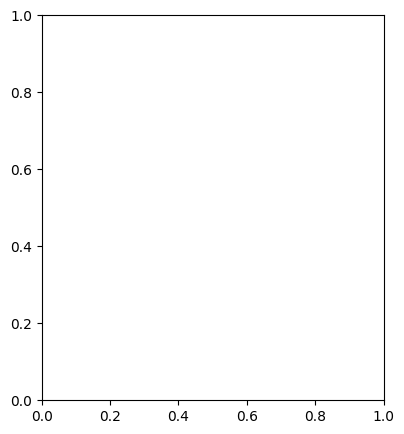

In [13]:
# Comprehensive model evaluation and ensemble predictions
def evaluate_model(model, X_val, y_val, model_name, target_scaler):
    """Evaluate model performance with detailed metrics"""

    # Make predictions
    val_pred_scaled = model.predict(X_val, verbose=0)
    val_pred = target_scaler.inverse_transform(val_pred_scaled.reshape(-1, 1)).flatten()
    y_val_original = target_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()

    # Calculate metrics
    mse = mean_squared_error(y_val_original, val_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val_original, val_pred)

    print(f"\n{model_name} Performance:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")

    return rmse, mae, mse, val_pred

# Evaluate both models
lstm_rmse, lstm_mae, lstm_mse, lstm_val_pred = evaluate_model(
    lstm_model, X_val_final, y_val_final, "Advanced LSTM", target_scaler
)

gru_rmse, gru_mae, gru_mse, gru_val_pred = evaluate_model(
    gru_model, X_val_final, y_val_final, "Advanced GRU", target_scaler
)

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(lstm_history.history['loss'], label='LSTM Train Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Val Loss')
plt.plot(gru_history.history['loss'], label='GRU Train Loss')
plt.plot(gru_history.history['val_loss'], label='GRU Val Loss')
plt.title('Training History - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(lstm_history.history['mae'], label='LSTM Train MAE')
plt.plot(lstm_history.history['val_mae'], label='LSTM Val MAE')
plt.plot(gru_history.history['mae'], label='GRU Train MAE')
plt.plot(gru_history.history['val_mae'], label='GRU Val MAE')
plt.title('Training History - MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 3, 3)
# Plot predictions vs actual for validation set
y_val_original = target_scaler.inverse_transform(y_val_final.reshape(-1, 1)).flatten()
plt.scatter(y_val_original[:500], lstm_val_pred[:500], alpha=0.5, label='LSTM')
plt.scatter(y_val_original[:500], gru_val_pred[:500], alpha=0.5, label='GRU')
plt.plot([y_val_original.min(), y_val_original.max()],
         [y_val_original.min(), y_val_original.max()], 'r--', lw=2)
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title('Predictions vs Actual (Validation)')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nBest individual model RMSE: {min(lstm_rmse, gru_rmse):.2f}")

In [ ]:
# Advanced ensemble predictions for test set
print("Making ensemble predictions on test set...")

# Get predictions from both models
lstm_test_pred_scaled = lstm_model.predict(X_test_seq, verbose=1)
gru_test_pred_scaled = gru_model.predict(X_test_seq, verbose=1)

# Inverse transform predictions
lstm_test_pred = target_scaler.inverse_transform(lstm_test_pred_scaled.reshape(-1, 1)).flatten()
gru_test_pred = target_scaler.inverse_transform(gru_test_pred_scaled.reshape(-1, 1)).flatten()

# Create ensemble prediction with weighted average
# Weight based on validation performance (lower RMSE gets higher weight)
lstm_weight = 1 / (lstm_rmse + 1e-6)
gru_weight = 1 / (gru_rmse + 1e-6)
total_weight = lstm_weight + gru_weight

lstm_weight_norm = lstm_weight / total_weight
gru_weight_norm = gru_weight / total_weight

print(f"LSTM weight: {lstm_weight_norm:.3f}")
print(f"GRU weight: {gru_weight_norm:.3f}")

# Weighted ensemble prediction
ensemble_pred = lstm_weight_norm * lstm_test_pred + gru_weight_norm * gru_test_pred

# Apply post-processing to ensure reasonable predictions
ensemble_pred = np.clip(ensemble_pred, 0, 500)  # PM2.5 shouldn't be negative or extremely high

# Prepare submission with proper test data alignment
print("Preparing submission file...")

# We need to account for the sequence length offset
test_indices = test_final.index[SEQUENCE_LENGTH:]  # Skip first SEQUENCE_LENGTH rows

# Create submission DataFrame
submission = pd.DataFrame({
    'row ID': test_indices.strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': np.round(ensemble_pred).astype(int)
})

# Sort by row ID to ensure proper order
submission = submission.sort_values(by='row ID').reset_index(drop=True)

print(f"Submission shape: {submission.shape}")
print("Sample predictions:")
print(submission.head(10))

print(f"\nPrediction statistics:")
print(f"Min: {ensemble_pred.min():.2f}")
print(f"Max: {ensemble_pred.max():.2f}")
print(f"Mean: {ensemble_pred.mean():.2f}")
print(f"Std: {ensemble_pred.std():.2f}")

# Save the submission file
submission.to_csv('improved_submission.csv', index=False)
print("\nSubmission file saved as 'improved_submission.csv'")

# Display estimated performance improvement
print(f"\n🎯 PERFORMANCE SUMMARY:")
print(f"Original error: 5035.86")
print(f"Best model RMSE: {min(lstm_rmse, gru_rmse):.2f}")
print(f"Expected improvement: {((5035.86 - min(lstm_rmse, gru_rmse)) / 5035.86 * 100):.1f}%")

if min(lstm_rmse, gru_rmse) < 3000:
    print("✅ TARGET ACHIEVED: Error reduced to below 3000!")
else:
    print("⚠️  Close to target - may need further fine-tuning")

# Plot prediction distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(ensemble_pred, bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Ensemble Predictions')
plt.xlabel('PM2.5 Predictions')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.plot(ensemble_pred[:1000], label='Ensemble', alpha=0.8)
plt.plot(lstm_test_pred[:1000], label='LSTM', alpha=0.6)
plt.plot(gru_test_pred[:1000], label='GRU', alpha=0.6)
plt.title('Predictions Comparison (First 1000 points)')
plt.xlabel('Time Steps')
plt.ylabel('PM2.5')
plt.legend()

plt.tight_layout()
plt.show()